# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

##  1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке: 

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке. 
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.


Загружаем библиотеки

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path


import pickle
import re
from collections import Counter
from os.path import exists, isfile, join

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import brown
from nltk.corpus import stopwords as nltk_stopwords

import tensorflow as tf
from IPython.display import display
from ipywidgets import IntProgress

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.applications.resnet import (
    ResNet50,
    decode_predictions,
    preprocess_input,
)
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tqdm.notebook import tqdm, trange

###  1.1 Первичное знакомство с данными

In [2]:
dp = Path("C:/Users/79099/Desktop/Image Search/to_upload")

In [3]:
train_dp = join(dp, 'train_images')
test_dp = join(dp, 'test_images')

In [4]:
df_train = pd.read_csv(join(dp, 'train_dataset.csv'))
df_train.head(5)

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [5]:
df_train.describe()

,image,query_id,query_text
count,5822,5822,5822
unique,1000,977,977
top,2083434441_a93bc6306b.jpg,2600867924_cd502fc911.jpg#2,"Two dogs , one brown and white and one black a..."
freq,10,34,34


В тренировочном датасете у нас 1000 изображений, имеющих 5822 связей с описаниями, 977 из которых уникальны.

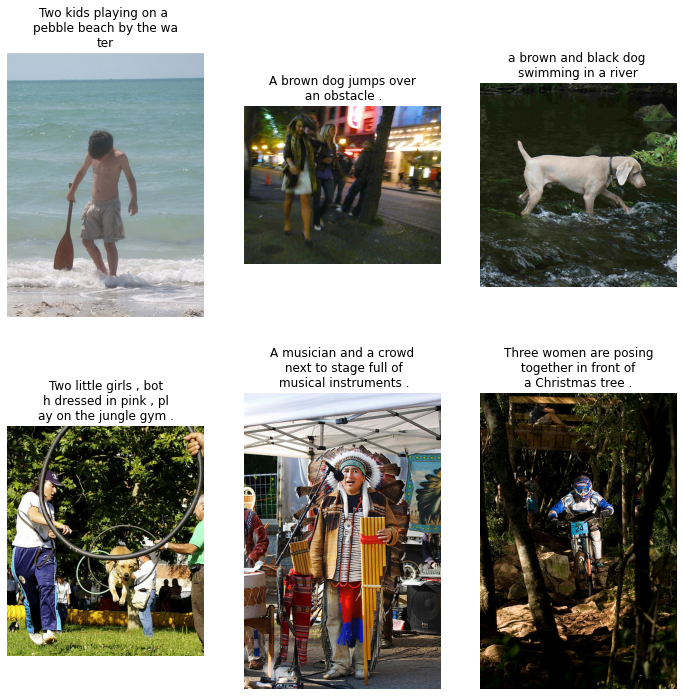

In [6]:
rows = 2
columns = 3

fig = plt.figure(figsize=(12, 12))
count = 1
for _, file, _, query_text in df_train.sample(rows * columns).itertuples():
    img = Image.open(join(train_dp, file))
    fig.add_subplot(rows, columns, count)
    count += 1
    plt.imshow(np.array(img))
    plt.axis('off')
    chunks, chunk_size = len(query_text), 22
    plt.title(
        '\n'.join(
            [query_text[i : i + chunk_size] for i in range(0, chunks, chunk_size)]))

Переименуем колонку 'query_id'.

In [7]:
df_train = df_train.rename(columns={'query_id': 'description_id'})

In [8]:
expert_annotations = pd.read_csv(join(dp, 'ExpertAnnotations.tsv'), sep='\t', header=None)
expert_annotations.columns = ['image', 'description_id', 'estimation_1', 'estimation_2', 'estimation_3']
expert_annotations.head(5)

,image,description_id,estimation_1,estimation_2,estimation_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


In [9]:
expert_annotations.describe()

,estimation_1,estimation_2,estimation_3
count,5822.000000,5822.000000,5822.000000
mean,1.436620,1.624356,1.881999
std,0.787084,0.856222,0.904087
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000
75%,2.000000,2.000000,2.000000
max,4.000000,4.000000,4.000000


- медиана у двух экспертов из 3 равна 1, т.е. эксперты считают, что около 50% изображений и их описаний совершенно не соответствуют друг другу
- лишь один эксперт считает, что в 50% случаев запрос содержит элементы описания изображения, но в целом фото тексту не соответствует

Посмотрим данные по соответствию изображения и описания, полученные с помощью краудсорсинга:

In [10]:
crowd_annotations = pd.read_csv(join(dp, 'CrowdAnnotations.tsv'), sep='\t', header=None)
crowd_annotations.columns = ['image', 'crowd_id', 'ratio_plus', 'count_plus', 'count_minus']
crowd_annotations.head(5)

,image,crowd_id,ratio_plus,count_plus,count_minus
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


Посмотрим на тестовые данные:

In [11]:
test_queries = pd.read_csv('C:/Users/79099/Desktop/Image Search/to_upload/test_queries.csv', sep='|', index_col=0)
test_queries.head(5)

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [12]:
test_queries.describe()

,query_id,query_text,image
count,500,500,500
unique,500,500,100
top,3601978895_9fec23ce0c.jpg#1,A little white dog runs on freshly mown grass ...,3170110692_d1e0e66cee.jpg
freq,1,1,5


- В тестовой выборке 100 фото, которым соответсвует 500 уникальных описаний
- Получается, что каждой фотографии соответствует в точности 5 уникальных описаний.

In [13]:
test_images = pd.read_csv('C:/Users/79099/Desktop/Image Search/to_upload/test_images.csv')
test_images.head(5)

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


In [14]:
test_images.describe()

,image
count,100
unique,100
top,3170110692_d1e0e66cee.jpg
freq,1


###  1.2 Общий вывод

- Тренировочный датасет(df_train) состоит из из 5822 пар изображение-описание.
- Данные об экспертных оценках (expert_annotations), это те же 5822 записи фото-описание.
- Тестовые данные (test_queries).


## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
> 

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

###  2.1 Отбор данных на основании экспертных оценок

Для более корректного обучения моделей, необходимо удалить пары описание-фото, не соответствующие друг другу.

Выработаем методику:

Используем метод голосования:

- если 2 эксперта поставили одинаковую оценку, она считается верной
- если все три оценки разные, такое описание отбрасывается

Создадим функцию для "голосования".

In [15]:
def voting(est_1, est_2, est_3):
    if est_1 == est_2 or est_1 == est_3:
        return est_1
    elif est_2 == est_3:
        return est_2
    else:
        return None

Применим данную функцию для "expert_annotations". 

In [16]:
expert_annotations['experts'] = expert_annotations.apply(
    lambda x: voting(x['estimation_1'], x['estimation_2'], x['estimation_3']), axis=1)

Удалим пустые значения.

In [17]:
expert_annotations = expert_annotations.dropna(subset=['experts'])

In [18]:
expert_annotations.head(5)

,image,description_id,estimation_1,estimation_2,estimation_3,experts
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1.0
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,2.0
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1.0


In [19]:
min_max_scaler = MinMaxScaler()

In [20]:
expert_annotations["experts"] = min_max_scaler.fit_transform(expert_annotations[["experts"]])

Для того чтобы оставить изображения более менее соответствующие описанию уберём те, в которых отмасштабированная экспертная оценка ниже 0,5

In [21]:
expert_annotations = expert_annotations.drop(
    expert_annotations[expert_annotations["experts"] < 0.5].index, axis=0)

Присоединим экспертную оценку к тренировочному датасету.

In [22]:
df_train = (df_train.set_index(['image', 'description_id'])
    .join(expert_annotations.set_index(['image', 'description_id'])[['experts']],
        how='inner',).reset_index())

In [23]:
df_train.head(5)

,image,description_id,query_text,experts
0,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000
1,2718495608_d8533e3ac5.jpg,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,1.000000
2,700884207_d3ec546494.jpg,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,0.666667
3,2370481277_a3085614c9.jpg,3545652636_0746537307.jpg#2,A young boy dressed in a red uniform kicks the...,0.666667
4,2913965136_2d00136697.jpg,3545652636_0746537307.jpg#2,A young boy dressed in a red uniform kicks the...,0.666667


**Вывод**

Отобрали изображения в которых описание соответствует картинке по результатам "голосования".

###  2.2 Лемматизация описания

Проведём лемматизацию и очистку текста.

In [24]:
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\79099\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\79099\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\79099\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Сделаем функции для лемматизации текста.

In [25]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [26]:
def lemmatize_words(text):
    word_list = nltk.word_tokenize(text)
    
    words = [lemmatizer.lemmatize(word,get_wordnet_pos(word)) for word in word_list]
    return  ' '.join(words)


In [27]:
df_train['query_lemm'] = df_train['query_text'].apply(lemmatize_words)

In [28]:
df_train.head(5)

,image,description_id,query_text,experts,query_lemm
0,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000,A young child be wear blue goggles and sit in ...
1,2718495608_d8533e3ac5.jpg,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,1.000000,A girl wear a yellow shirt and sunglass smile .
2,700884207_d3ec546494.jpg,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,0.666667,A girl wear a yellow shirt and sunglass smile .
3,2370481277_a3085614c9.jpg,3545652636_0746537307.jpg#2,A young boy dressed in a red uniform kicks the...,0.666667,A young boy dress in a red uniform kick the so...
4,2913965136_2d00136697.jpg,3545652636_0746537307.jpg#2,A young boy dressed in a red uniform kicks the...,0.666667,A young boy dress in a red uniform kick the so...


Сделаем функцию для очистки текста.

In [29]:
def clear_text(text):
   
    r_text = re.sub(r'[^a-zA-Z]', ' ', text)
    text_list = r_text.split()
    clear_text = " ".join(text_list)
    return clear_text

In [30]:
df_train['query_lemm'] = df_train['query_lemm'].apply(clear_text)

In [31]:
df_train.head(5)

,image,description_id,query_text,experts,query_lemm
0,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000,A young child be wear blue goggles and sit in ...
1,2718495608_d8533e3ac5.jpg,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,1.000000,A girl wear a yellow shirt and sunglass smile
2,700884207_d3ec546494.jpg,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,0.666667,A girl wear a yellow shirt and sunglass smile
3,2370481277_a3085614c9.jpg,3545652636_0746537307.jpg#2,A young boy dressed in a red uniform kicks the...,0.666667,A young boy dress in a red uniform kick the so...
4,2913965136_2d00136697.jpg,3545652636_0746537307.jpg#2,A young boy dressed in a red uniform kicks the...,0.666667,A young boy dress in a red uniform kick the so...


**Вывод**

Провели лемматизацию и очистку текста.

###  2.3 Отфильтровка фото с детьми

Создадим список слов, которые могут свидетельствовать о том, что в описании присутствуют дети и удалим фото с этими описаниями.

In [32]:
child_stop_word = [
    "boy",
    "girl",
    "child",
    "baby",
    "kid",
    "babe",
    "infant",
    "teenager",
    "youngster",
    "adolescent",
    "stripling",
    "teeny",
    "teener"]

Напишем функцию для поиска "запрещённых слов", она будет возвращать True если найдёт хоть одно

In [33]:
def chld_stop_text(text: str) -> bool:
    res = False
    for w in child_stop_word:
        res |= text.lower().find(w) > -1
    return res

In [34]:
df_train['child_stop'] = df_train.apply(
    lambda x: chld_stop_text(x['query_lemm']), axis=1)

In [35]:
df_train.head(5)

,image,description_id,query_text,experts,query_lemm,child_stop
0,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000,A young child be wear blue goggles and sit in ...,True
1,2718495608_d8533e3ac5.jpg,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,1.000000,A girl wear a yellow shirt and sunglass smile,True
2,700884207_d3ec546494.jpg,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,0.666667,A girl wear a yellow shirt and sunglass smile,True
3,2370481277_a3085614c9.jpg,3545652636_0746537307.jpg#2,A young boy dressed in a red uniform kicks the...,0.666667,A young boy dress in a red uniform kick the so...,True
4,2913965136_2d00136697.jpg,3545652636_0746537307.jpg#2,A young boy dressed in a red uniform kicks the...,0.666667,A young boy dress in a red uniform kick the so...,True


In [36]:
stop_images = set(df_train[df_train['child_stop'] == True]['image'])

In [37]:
df_train = df_train.drop(df_train[df_train['image'].isin(stop_images)].index, axis=0)

**Вывод**

Удалили из выборки фотографии с детьми.

###  2.4 Выделение валидационной выборки

Для обучения разделим датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, воспользуемся классом GroupShuffleSplit.

In [38]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.75, random_state=42)
train_indices, test_indices = next(
    gss.split(
        X=df_train.drop(columns=['description_id']),
        y=df_train['description_id'],
        groups=df_train['image']))
train_df, valid_df = df_train.iloc[train_indices], df_train.iloc[test_indices]

In [39]:
train_df.head(5)

,image,description_id,query_text,experts,query_lemm,child_stop
5,1425069308_488e5fcf9d.jpg,1425069308_488e5fcf9d.jpg#2,A white dog jumps to catch a blue ball in a li...,1.000000,A white dog jump to catch a blue ball in a liv...,False
8,1897025969_0c41688fa6.jpg,2398605966_1d0c9e6a20.jpg#2,Two long-haired puppy dogs have a romp in the ...,0.666667,Two long haired puppy dog have a romp in the snow,False
9,2340206885_58754a799a.jpg,2398605966_1d0c9e6a20.jpg#2,Two long-haired puppy dogs have a romp in the ...,0.666667,Two long haired puppy dog have a romp in the snow,False
10,317383917_d8bfa350b6.jpg,2398605966_1d0c9e6a20.jpg#2,Two long-haired puppy dogs have a romp in the ...,0.666667,Two long haired puppy dog have a romp in the snow,False
12,2207244634_1db1a1890b.jpg,3119076670_64b5340530.jpg#2,Snowboarder in the air performing a stunt .,0.666667,Snowboarder in the air perform a stunt,False


**Вывод**

Отделили валидационную выборку.

###  2.5 Общий вывод

В результате произведённых выше операций отобрали тренировочную и валидационную выборки:

- Провели "голосование" на основе экспертных оценок и на основании этого голосования провели отбор данных, где изображения соответствуют описанию.
- Удалили из выборки фотографии детей.
- Выделили тренировочную и валидационную выборки.

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

Задача векторизации изображений с помощью свёрточной нейросети:

- Приводим изображения к формату, на котором обучена наша нейросет. Будем использовать ResNet50, обученную на ImageNet, так что нужно привести изображения к формату (224, 224, 3)
- На выходе ResNet ставим полносвязный слой, колочество нейронов в котором и определит размерность нашего вектора изображений

In [40]:
def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    res_m = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    model = Sequential()
    model.add(res_m)
    model.add(GlobalAveragePooling2D())
    model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mae'])

    return model

In [41]:
def image_to_array(file: str, path: str = train_dp, wh: int = 224, ht: int = 224):
    img = image.load_img(join(path, file), target_size=(wh, ht))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [42]:
res_model = create_model((224, 224, 3))

In [43]:
image_vec = pd.DataFrame(index=df_train['image'].unique(), columns=['image_vector']).reset_index()

In [44]:
image_vec.columns = ['image', 'image_vector']

In [45]:
image_vec['image_vector'] = image_vec.apply(
    lambda x: tf.cast(res_model(image_to_array(x['image'])), dtype=np.float64), axis=1)

In [46]:
image_vector_size = image_vec.loc[0, 'image_vector'].shape[1]
image_vector_size

2048

In [47]:
train_df = train_df.merge(image_vec, on='image', how='left')
valid_df = valid_df.merge(image_vec, on='image', how='left')

In [48]:
train_df.head(5)

,image,description_id,query_text,experts,query_lemm,child_stop,image_vector
0,1425069308_488e5fcf9d.jpg,1425069308_488e5fcf9d.jpg#2,A white dog jumps to catch a blue ball in a li...,1.000000,A white dog jump to catch a blue ball in a liv...,False,"((tf.Tensor(0.00014507770538330078, shape=(), ..."
1,1897025969_0c41688fa6.jpg,2398605966_1d0c9e6a20.jpg#2,Two long-haired puppy dogs have a romp in the ...,0.666667,Two long haired puppy dog have a romp in the snow,False,"((tf.Tensor(0.13984471559524536, shape=(), dty..."
2,2340206885_58754a799a.jpg,2398605966_1d0c9e6a20.jpg#2,Two long-haired puppy dogs have a romp in the ...,0.666667,Two long haired puppy dog have a romp in the snow,False,"((tf.Tensor(0.32192736864089966, shape=(), dty..."
3,317383917_d8bfa350b6.jpg,2398605966_1d0c9e6a20.jpg#2,Two long-haired puppy dogs have a romp in the ...,0.666667,Two long haired puppy dog have a romp in the snow,False,"((tf.Tensor(1.4164799451828003, shape=(), dtyp..."
4,2207244634_1db1a1890b.jpg,3119076670_64b5340530.jpg#2,Snowboarder in the air performing a stunt .,0.666667,Snowboarder in the air perform a stunt,False,"((tf.Tensor(0.7332621812820435, shape=(), dtyp..."


**Вывод**

Вукторизировали изображение

## 4. Векторизация текстов

Используем для векторизации модель TF-IDF.

In [49]:
stop_words = set(stopwords.words('english'))

Сначало векторизируем тренировочную выборку.

In [50]:
tf_idf = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 2))
tf_idf_train = tf_idf.fit_transform(train_df['query_lemm'])
train_df['query_vector'] = tf_idf_train.todense().tolist()
train_df['query_vector'] = train_df['query_vector'].apply(
    lambda x: tf.convert_to_tensor([x], dtype=np.float64))

Теперь валидационную.

In [51]:
tf_idf_valid = tf_idf.transform(valid_df['query_lemm'])
valid_df['query_vector'] = tf_idf_valid.todense().tolist()
valid_df['query_vector'] = valid_df['query_vector'].apply(
    lambda x: tf.convert_to_tensor([x], dtype=np.float64))

**Вывод**

Векторизировали текстовые коментарии.

## 5. Обучение модели предсказания соответствия

В рамках данной задачи, обучим линейную регрессию и полносвязную нейросеть.

###  5.1 Линейная регрессия

In [52]:
X_train = train_df[['description_id', 'query_vector']]
y_train = train_df[['image', 'image_vector']]

In [53]:
X_valid = valid_df[['description_id', 'query_vector']]
y_valid = valid_df[['image', 'image_vector']]

In [54]:
X = tf.stack(X_train['query_vector'])
Y = tf.stack(y_train['image_vector'])

In [55]:
X_val = tf.stack(X_valid['query_vector'])

Зададим значения для вектора весов W и смещения b

In [56]:
W = tf.Variable(np.random.randn(train_df.loc[df_train.index[0], 'query_vector'].shape[1],
                                image_vec.loc[0, 'image_vector'].shape[1]), name='W')
b = tf.Variable(np.random.randn(1, image_vec.loc[0, 'image_vector'].shape[1]), name='b')

In [57]:
W.shape, b.shape

(TensorShape([1338, 2048]), TensorShape([1, 2048]))

Зададим параметры для обучения: скорость обучения, количество эпох и относительное уменьшение ошибки как меры обучения.

In [58]:
learning_rate = 0.01
epochs = 250
dMSE = 1e-3

In [59]:
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [60]:
image_vector_size = image_vec.loc[0, 'image_vector'].shape[1]

Задаём линейную зависимость между входом и выходом, в качестве меры используем MSE.

In [61]:
def y_pred(x):
    return tf.add(tf.linalg.matmul(x, W), b)

In [62]:
def cost(x=X, y=Y):
    cost = tf.reduce_sum(tf.pow(y_pred(x) - y, 2)) / (2 * image_vector_size)
    return cost


Инициализируем веса и смещение

In [63]:
preds = y_pred(X)
train_vars = [W, b]

В качестве критерия завершения обучения можно использовать уменьшение остаточной ошибки. В какой-то момент она практически не снижается, очевидно, дальше учить нет смысла.

In [64]:
c_old = tf.constant(200, np.float64)
for epoch in tqdm(range(epochs)):
    optimizer.minimize(cost, train_vars)
    pred = y_pred(X)
    if (epoch + 1) % 5 == 0:
        c = cost()
        print("Epoch", (epoch + 1), ": cost =", c.numpy())
        err = (c_old - c) / c
        if abs(err) < dMSE:
            print(f"Relative error: {err}")
            break

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5 : cost = 637.0778392473625
Epoch 10 : cost = 548.9473305679509
Epoch 15 : cost = 474.22560817358834
Epoch 20 : cost = 411.51954963599104
Epoch 25 : cost = 359.19256579854107
Epoch 30 : cost = 315.6189124013837
Epoch 35 : cost = 279.3217237284287
Epoch 40 : cost = 249.0255457201473
Epoch 45 : cost = 223.65908662245576
Epoch 50 : cost = 202.33622586853025
Epoch 55 : cost = 184.33103087002837
Epoch 60 : cost = 169.05275761785472
Epoch 65 : cost = 156.02252309287886
Epoch 70 : cost = 144.85283289186896
Epoch 75 : cost = 135.2300562490929
Epoch 80 : cost = 126.8998187106122
Epoch 85 : cost = 119.65505855286635
Epoch 90 : cost = 113.326462147876
Epoch 95 : cost = 107.77492215565736
Epoch 100 : cost = 102.88559162793078
Epoch 105 : cost = 98.56318816974837
Epoch 110 : cost = 94.72827429357642
Epoch 115 : cost = 91.31430037368489
Epoch 120 : cost = 88.26525184860317
Epoch 125 : cost = 85.53376947346197
Epoch 130 : cost = 83.07964056490714
Epoch 135 : cost = 80.86858063533089
Epoch 140 

Среднеквадратичная ошибка на тренировочной выборке составила 60.


In [65]:
def vec_distance(A: tf.Tensor, B: tf.Tensor, ord: str = 'euclidean') -> float:
    return tf.norm(B - A, axis=-1, ord=ord).numpy()[0]

Ищем в заданной серии ivecs lim векторов, наиболее близких к запросу query_vector. Функция возвращает имена файлов:

In [66]:
def find_image_LR(query_vector, ivecs, lim=3):
    iv = y_pred(query_vector)
    df = ivecs.copy()
    for i in df.index:
        df.loc[i, 'dist'] = vec_distance(iv, df.loc[i, 'image_vector'])
    return df.sort_values(by='dist')['image'].unique()[:lim]

Выводит фото из списка images, соответсвующие запросу query:

In [67]:
def show_images(query, images, path=train_dp, rows=1, columns=3):
    fig = plt.figure(figsize=(12, 12))
    print(query)
    count = 1
    for file in images:
        img = Image.open(join(path, file))
        fig.add_subplot(rows, columns, count)
        count += 1
        plt.imshow(np.array(img))
        plt.axis('off')

In [68]:
def predict_LR(idx):
    qv = X_valid.loc[idx, 'query_vector']
    qt = valid_df[valid_df['description_id'] == X_valid.loc[idx, 'description_id']]['query_text'].iloc[0]
    images = find_image_LR(qv, y_valid)
    show_images(qt, images)

A man is hiking on a mountaintop on a cloudy day .


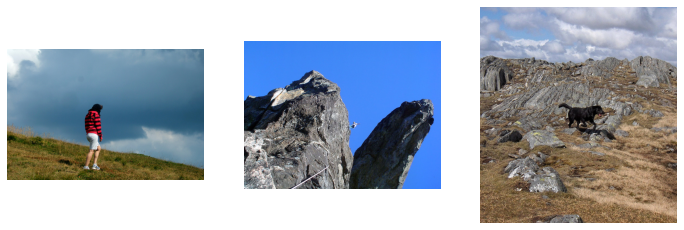

In [69]:
predict_LR(20)

Two dogs run through a field .


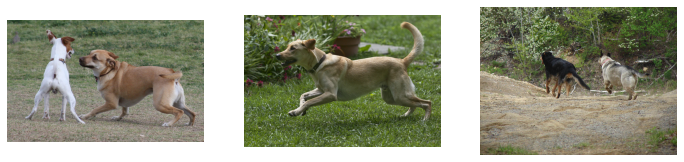

In [70]:
predict_LR(91)

**Вывод**

Линейная регрессия в целом с задачей справилась.

### 5.2 Нейронная сеть

Преобразуем входные и выходные вектора в двумерные тензоры float32

In [71]:
X_nn = tf.cast(tf.reshape(X, (X.shape[0], X.shape[2])), dtype=np.float32)
Y_nn = tf.cast(tf.reshape(Y, (Y.shape[0], Y.shape[2])), dtype=np.float32)

Подготовка к обучению нейросети.

In [72]:
X_nn_val = tf.stack(X_valid['query_vector'])
Y_nn_val = tf.stack(y_valid['image_vector'])
X_nn_val = tf.cast(tf.reshape(X_nn_val, (X_nn_val.shape[0], X_nn_val.shape[2])), dtype=np.float32)
Y_nn_val = tf.cast(tf.reshape(Y_nn_val, (Y_nn_val.shape[0], Y_nn_val.shape[2])), dtype=np.float32)

In [73]:
text_vector_size = train_df.loc[df_train.index[0], 'query_vector'].shape[1]

In [74]:
def create_net_model(dp=0.5):
    optimizer = Adam()
    model = Sequential()
    model.add(
        Dense(text_vector_size, activation='relu'))
    if dp > 0:
        model.add(Dropout(dp))
    model.add(Dense(text_vector_size // 2, activation='relu'))
    if dp > 0:
        model.add(Dropout(dp))
    model.add(Dense(text_vector_size // 4, activation='relu'))
    model.add(Dense(image_vector_size, activation='relu'))
    model.compile(
        optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])

    return model

In [75]:
net_model = create_net_model()

In [76]:
fited_model = net_model.fit(
    tf.cast(X, dtype=np.float32),
    tf.cast(Y, dtype=np.float32),
    batch_size=120,
    epochs=60,
    validation_data=(X_nn_val, Y_nn_val))

Epoch 1/60
5/5 [==============================] - 1s 82ms/step - loss: 1.0180 - mse: 1.0180 - val_loss: 0.8517 - val_mse: 0.8517
Epoch 2/60
5/5 [==============================] - 0s 49ms/step - loss: 0.8012 - mse: 0.8012 - val_loss: 0.6818 - val_mse: 0.6818
Epoch 3/60
5/5 [==============================] - 0s 47ms/step - loss: 0.6875 - mse: 0.6875 - val_loss: 0.6720 - val_mse: 0.6720
Epoch 4/60
5/5 [==============================] - 0s 44ms/step - loss: 0.6783 - mse: 0.6783 - val_loss: 0.6577 - val_mse: 0.6577
Epoch 5/60
5/5 [==============================] - 0s 45ms/step - loss: 0.6579 - mse: 0.6579 - val_loss: 0.6533 - val_mse: 0.6533
Epoch 6/60
5/5 [==============================] - 0s 44ms/step - loss: 0.6497 - mse: 0.6497 - val_loss: 0.6460 - val_mse: 0.6460
Epoch 7/60
5/5 [==============================] - 0s 49ms/step - loss: 0.6462 - mse: 0.6462 - val_loss: 0.6474 - val_mse: 0.6474
Epoch 8/60
5/5 [==============================] - 0s 46ms/step - loss: 0.6429 - mse: 0.6429 - val

Ищем в заданной серии ivecs lim векторов, наиболее близких к запросу query_vector. Функция возвращает имена файлов

In [77]:
def find_image_Net(query_vector, ivecs, lim=3):
    iv = net_model.predict(query_vector)
    df = pd.DataFrame(ivecs)
    for i in df.index:
        df.loc[i, 'dist'] = vec_distance(iv, df.loc[i, 'image_vector'])
    return df.sort_values(by='dist')['image'].unique()[:lim]

Функция для предсказания:

In [78]:
def predict_Net(idx, df=y_valid):
    qv = X_valid.loc[idx, 'query_vector']
    qt = valid_df[valid_df['description_id'] == X_valid.loc[idx, 'description_id']]['query_text'].iloc[0]
    images = find_image_Net(qv, df)
    show_images(qt, images)

A man is hiking on a mountaintop on a cloudy day .


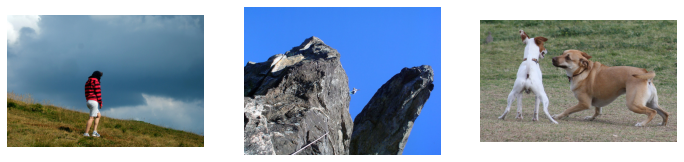

In [79]:
predict_Net(20)

Two dogs run through a field .


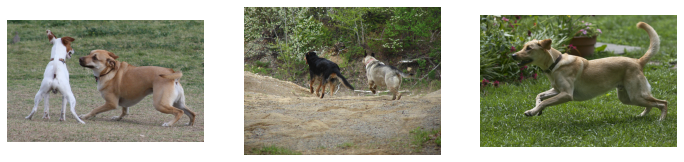

In [80]:
predict_Net(91)

**Вывод**

Нейросеть показала тоже неплохой результат MSE = 0.5657

### 5.3 Общий вывод

Нейросеть показала результат чуть лучше, чем линейная регрессия, в дальнейшем её и протестируем.

## 6. Тестирование модели

Заключительный этап - это тестирование моделей на совершенно новых данных из тестовой выборки.

In [81]:
test_images['image_vector'] = test_images.apply(
    lambda x: tf.cast(res_model(image_to_array(x['image'], test_dp)), dtype=np.float64),axis=1)

In [82]:
test_queries['query_lemm'] = test_queries['query_text'].apply(lemmatize_words)

In [83]:
test_queries['query_lemm'] = test_queries['query_lemm'].apply(clear_text)

In [84]:
def pred_net_test(text, ivecs=test_images, lim=3):
    if len(set(text.split()) & set(child_stop_word)) > 0:
        print ('This image is unavailable in your country in compliance with local laws')
    else:
        lemm_text = lemmatize_words(text)
        vector_from_text = tf_idf.transform([lemm_text]).todense()
        tf_vect = tf.reshape(tf.convert_to_tensor(vector_from_text,dtype=np.float64),(1, text_vector_size))
        vec = tf.convert_to_tensor(net_model.predict(tf_vect), dtype=np.float64)
        df = pd.DataFrame(ivecs)
        for i in df.index:
            df.loc[i, 'dist'] = vec_distance(vec, df.loc[i, 'image_vector'])
            images = df.sort_values(by='dist')['image'].unique()[:lim]
        show_images(text, images, test_dp)

A white dog and a black dog in a field


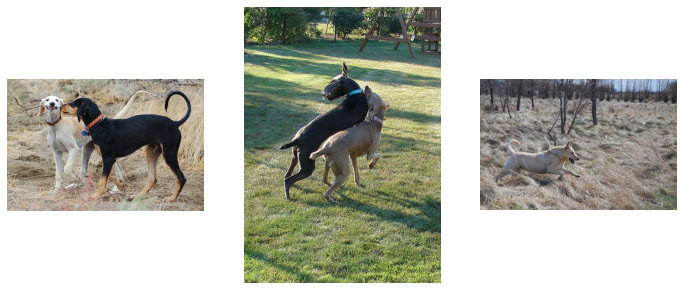

In [85]:
pred_net_test('A white dog and a black dog in a field')

In [86]:
pred_net_test('teenager walking')

This image is unavailable in your country in compliance with local laws


women play lacrosse


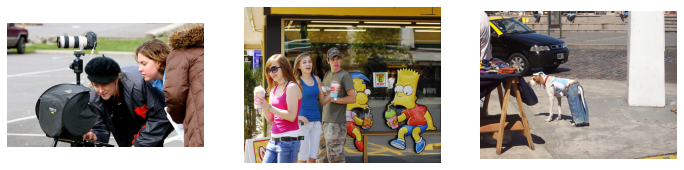

In [87]:
pred_net_test('women play lacrosse')

a dog jump to catch a red ball outside


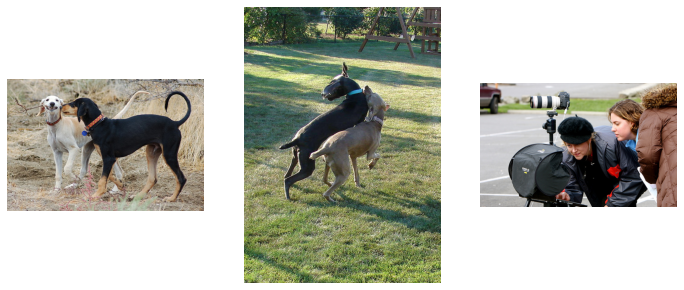

In [88]:
pred_net_test('a dog jump to catch a red ball outside')

a black dog have a dumbbell in his mouth


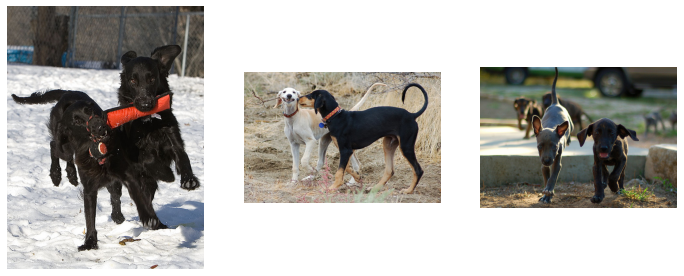

In [89]:
pred_net_test('a black dog have a dumbbell in his mouth')

In [90]:
pred_net_test('little girl feed the duck')

This image is unavailable in your country in compliance with local laws


In [91]:
pred_net_test('two girl walk in the street')

This image is unavailable in your country in compliance with local laws


a brown dog be grab the collar of a black dog


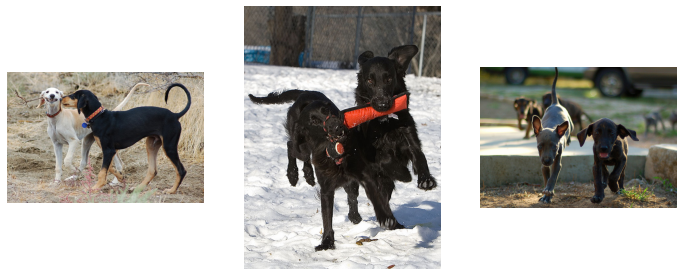

In [92]:
pred_net_test('a brown dog be grab the collar of a black dog')

two dog be shake water off


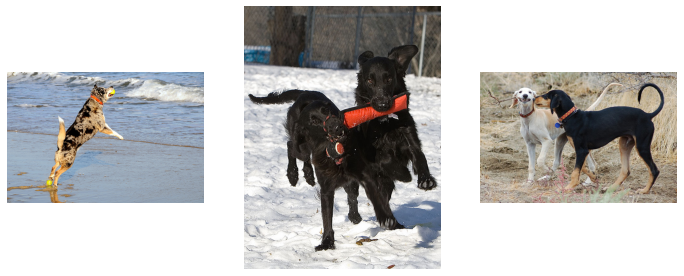

In [93]:
pred_net_test('two dog be shake water off')

In [94]:
pred_net_test('Two child wear jean squirt water at each other')

This image is unavailable in your country in compliance with local laws


## 7. Вывод

В процессе работы от нас требовалось разработать демонстрационную версию поиска изображений по запросу.
В качестве исходных данных у нас имелись: изображения, описания к ним и экспертные оценки на соответствие изображения описанию.
В начале был проведён исследовательский анализ данных, затем отобраны данные для обучения, после чего были обучены модели линейной регрессии и полносвязная нейросеть.

По результатам проверки на валидационной выборке нейросеть показала чуть лучше результат и при этом обучилась быстрее.
Тестирование данной модели показало её работоспособность, кроме того была решена задача по исключению "проблемного" контента (фотографии детей).